In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from RevMNIST2 import *

import torch.nn.functional as F

from tqdm import tqdm
from statistics import fmean

In [2]:
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output
    return hook

In [3]:
trainset = RevMNIST2(root='./data/', train=True, offset=None, filt_labels=None)
testset = RevMNIST2(root='./data/', train=False, offset=None, filt_labels=None)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

In [4]:
trainset.__len__(), testset.__len__()

(60000, 10000)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
x1, x2, x0, label, t1, t2 = next(iter(testloader))
x1.size(), x2.size(), label.size(), t1.size(), t2.size()

c:\Users\goate\Desktop\internship\experiments\MNIST\RevMNIST2.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (image1, image2, torch.tensor(image).permute(2, 0, 1), label, torch.tensor(T1[:, 2]), torch.tensor(T2[:, 2]))


(torch.Size([512, 1, 28, 28]),
 torch.Size([512, 1, 28, 28]),
 torch.Size([512]),
 torch.Size([512, 2]),
 torch.Size([512, 2]))

In [7]:
# Define the neural network class
class Regressor(torch.nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()

        self.emb1 = None
        self.emb2 = None
        # The input size is 28x28, which is 784
        self.fcb = torch.nn.Sequential(
            torch.nn.Linear(2 * 28 * 28, 2 * 28 * 28),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * 28 * 28, 2 * 28 * 28),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * 28 * 28, 28 * 28),
            torch.nn.ReLU(),
            torch.nn.Linear(28 * 28, 28 * 28),
            torch.nn.ReLU(),
            torch.nn.Linear(28 * 28, 28),
            torch.nn.ReLU(),
            torch.nn.Linear(28, 28),
            torch.nn.ReLU(),
            torch.nn.Linear(28, 4)
        )

    def forward(self, x):
        x = x.view(-1, 2*28*28)  # Flatten the 28x28 input to a 784 vector
        x = self.fcb(x)
        return x

# Example usage
model = Regressor().to(device)

model.fcb[11].register_forward_hook(get_features("embedding"))

In [37]:
total_params = sum(p.numel() for p in model.parameters())
total_params

6788828

In [8]:
'''
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.emb1 = None
        self.emb2 = None
        # Define the layers of the CNN
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, stride=1)
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=2, kernel_size=5, stride=1)
        
        # Calculate the size after convolutions to flatten the feature map
        self.fc1 = torch.nn.Linear(2 * 19 * 19, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 4)
    
    def forward(self, x):
        # Apply convolutions with ReLU activation and max pooling

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        batch_size, channels, x_dim, y_dim = x.size()

        self.emb1 = x[:, 0, :, :].flatten(start_dim=1)
        self.emb2 = x[:, 1, :, :].flatten(start_dim=1)
        
        # Flatten the output from the conv layers
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Final output layer (no activation since this is often used for classification)
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleCNN()

# Print the model summary
print(model)
'''

'\nclass SimpleCNN(torch.nn.Module):\n    def __init__(self):\n        super(SimpleCNN, self).__init__()\n        self.emb1 = None\n        self.emb2 = None\n        # Define the layers of the CNN\n        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1)\n        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, stride=1)\n        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=2, kernel_size=5, stride=1)\n        \n        # Calculate the size after convolutions to flatten the feature map\n        self.fc1 = torch.nn.Linear(2 * 19 * 19, 128)\n        self.fc2 = torch.nn.Linear(128, 64)\n        self.fc3 = torch.nn.Linear(64, 4)\n    \n    def forward(self, x):\n        # Apply convolutions with ReLU activation and max pooling\n\n        x = F.relu(self.conv1(x))\n        x = F.relu(self.conv2(x))\n        x = F.relu(self.conv3(x))\n\n        batch_size, channels, x_dim, y_dim = x.size()\n\n        self.emb1 = x[

In [9]:
'''
class BiggerCNN(torch.nn.Module):
    def __init__(self):
        super(BiggerCNN, self).__init__()
        self.emb1 = None
        self.emb2 = None

        # Define a deeper CNN architecture with more layers and channels
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1)
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1)
        self.conv6 = torch.nn.Conv2d(in_channels=64, out_channels=2, kernel_size=3, stride=1)

        # Adjust the size calculation after convolutions for flattening
        self.fc1 = torch.nn.Linear(2 * 16 * 16, 512)  # The dimension here depends on the input size and conv layers
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 128)
        self.fc4 = torch.nn.Linear(128, 64)
        self.fc5 = torch.nn.Linear(64, 4)  # Assuming a final output of 4 classes

    def forward(self, x):
        # Apply convolutions with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        batch_size, channels, x_dim, y_dim = x.size()

        # print(f'dim x: ({x_dim}, {y_dim})')

        # Extract embeddings after the final conv layer
        self.emb1 = x[:, 0, :, :].flatten(start_dim=1)
        self.emb2 = x[:, 1, :, :].flatten(start_dim=1)

        # Flatten the output from the conv layers
        x = x.view(x.size(0), -1)

        # Apply fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        # Final output layer (no activation since this is often used for classification)
        x = self.fc5(x)
        return x

# Initialize the model
model = BiggerCNN().to(device)

# Print the model summary
print(model)
'''

"\nclass BiggerCNN(torch.nn.Module):\n    def __init__(self):\n        super(BiggerCNN, self).__init__()\n        self.emb1 = None\n        self.emb2 = None\n\n        # Define a deeper CNN architecture with more layers and channels\n        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, stride=1)\n        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)\n        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)\n        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1)\n        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1)\n        self.conv6 = torch.nn.Conv2d(in_channels=64, out_channels=2, kernel_size=3, stride=1)\n\n        # Adjust the size calculation after convolutions for flattening\n        self.fc1 = torch.nn.Linear(2 * 16 * 16, 512)  # The dimension here depends on the input size and conv lay

In [10]:
'''
def my_loss(feat1, feat2, out, t1, t2):
    return torch.nn.MSELoss()(t2 - out[:, -2:], t1 - out[:, :2]) + 0.01*torch.norm(torch.norm(t2 - t1, dim=1) - torch.diag(torch.matmul(feat2, feat1.T))) # the second part is a fancy way to compute the dot product since we have a batch size
    # return torch.norm(torch.norm(t2 - t1, dim=1) - torch.diag(torch.matmul(feat2, feat1.T)))
'''

'\ndef my_loss(feat1, feat2, out, t1, t2):\n    return torch.nn.MSELoss()(t2 - out[:, -2:], t1 - out[:, :2]) + 0.01*torch.norm(torch.norm(t2 - t1, dim=1) - torch.diag(torch.matmul(feat2, feat1.T))) # the second part is a fancy way to compute the dot product since we have a batch size\n    # return torch.norm(torch.norm(t2 - t1, dim=1) - torch.diag(torch.matmul(feat2, feat1.T)))\n'

In [11]:
vdot = torch.vmap(torch.dot)

def my_loss(feat1, feat2, out, t1, t2):
    # return torch.nn.MSELoss()(t2 - out[:, -2:], t1 - out[:, :2]) + 0.01*torch.norm(torch.norm(t2 - t1, dim=1) - vdot(feat1, feat2)) # the second part is a fancy way to compute the dot product since we have a batch size
    return torch.norm(torch.norm(t2 - t1, dim=1) - vdot(feat1, feat2))

In [12]:
def get_test_error(model, dataloader):
    L2_dist = lambda feat1, feat2: torch.norm(feat1 - feat2, dim=1)
    model.eval()
    with torch.no_grad():
        correct = 0
        for x1, x2, _, _, t1, t2 in iter(dataloader):
            t1 = t1.to(device)
            t2 = t2.to(device)
            # out = model(torch.concat((x1, x2))) # to put the 2 images as one input vector
            out = model(torch.concat((x1, x2), dim=1).to(device))
            correct += L2_dist(t2 - out[:, -2:], t1 - out[:, :2]).sum()
        return float(correct/len(dataloader.dataset))

In [13]:
def display_losses_and_accuracies(loss, test_error, epochs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([*range(epochs)], loss, 'b-', label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot([*range(epochs)], test_error, 'b-', label='Test Error')
    plt.title('Test Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
'''
def loss_func(feat1, feat2): # TODO: re-think better the second part
    # feat1 = tau2 - tau1
    # feat2 = output[:-2] - output[:2]
    # maximize average cosine similarity
    return -F.cosine_similarity(feat1, feat2) + torch.norm(feat1 - feat2)

loss_func(torch.randn(3, 2), torch.randn(3, 2))
'''

'\ndef loss_func(feat1, feat2): # TODO: re-think better the second part\n    # feat1 = tau2 - tau1\n    # feat2 = output[:-2] - output[:2]\n    # maximize average cosine similarity\n    return -F.cosine_similarity(feat1, feat2) + torch.norm(feat1 - feat2)\n\nloss_func(torch.randn(3, 2), torch.randn(3, 2))\n'

In [15]:
def train(model, optimizer, trainloader, testloader, lossfunc, epochs=10):
    loss = []
    test_error = []

    for epoch in tqdm(range(epochs)):
        losses_per_epoch = []
        test_error.append(get_test_error(model, testloader))
        model.train()
        for x1, x2, x0, y, t1, t2 in iter(trainloader):
            t1 = t1.to(device)
            t2 = t2.to(device)
            # out = model(torch.concat((x1, x2)))
        
            model(torch.concat((x1, x0), dim=1).to(device))
            emb1 = features["embedding"].clone()
            model(torch.concat((x0, x2), dim=1).to(device))
            emb2 = features["embedding"].clone()
            
            out = model(torch.concat((x1, x2), dim=1).to(device))
            # l = lossfunc(t2 - out[:, -2:], t1 - out[:, :2]) # remember to use MSE as loss func (loss with the first model)
            l = lossfunc(emb1, emb2, out, t1, t2)
            losses_per_epoch.append(l)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        loss.append(fmean(losses_per_epoch))
    
    return (loss, test_error)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# lossfunc = torch.nn.MSELoss()
lossfunc = my_loss

In [17]:
train_loss, test_error = train(model=model, optimizer=optimizer, trainloader=trainloader, testloader=testloader, lossfunc=lossfunc, epochs=20)

100%|██████████| 20/20 [06:01<00:00, 18.07s/it]


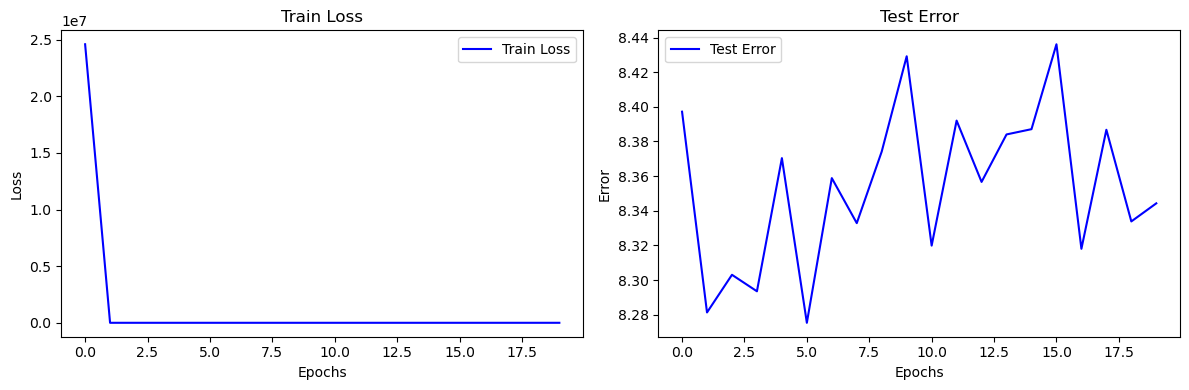

In [72]:
display_losses_and_accuracies(torch.tensor(train_loss), test_error, epochs=20)

In [19]:
terr = torch.tensor(test_error)
print(f'Test error min: {terr.min():.2f}, max: {terr.max():.2f}, mean: {terr.mean():.2f}, std: {terr.std():.2f}')

Test error min: 8.28, max: 8.44, mean: 8.35, std: 0.05


In [69]:
from scipy.linalg import circulant

for p in model.parameters():
    if p.dim() > 1:
        if p.size(0) == p.size(1):
            A = p.detach().cpu()
            B = torch.tensor(circulant([*range(p.size(0))])).float()
            eigA = torch.linalg.eig(A).eigenvectors
            eigB = torch.linalg.eig(B).eigenvectors
            print(torch.linalg.norm(eigA - eigB))

tensor(56.0033)
tensor(56.0377)
tensor(39.5653)
tensor(7.5030)
